# Additional Datasets
C. Heiser, 2019

---
__The purpose of this notebook is to evaluate our structural preservation metrics on further datasets to confirm utility. Two datasets from the [UMAP _Nat. Biotech._ paper (Becht, _et al._ 2018)](https://www.nature.com/articles/nbt.4314) are evaluated to cover some key features of our framework:__  
* Larger datasets by number of cells
* CyTOF data in addition to scRNA-seq
* Previously annotated cell clusters for local and neighborhood structural preservation
* Confirmation of findings by Becht, _et al._ using our metrics to confirm utility and resolve claim of global vs. local structure preservation by UMAP compared to t-SNE

In [2]:
import sys
sys.path.append('../')
from fcc_utils import *

---
### Mouse Cell Atlas Hematopoeitic Dataset
[GSE108097](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108097)

In [3]:
%time hemato = sc.read('../inputs/mca_hemato.h5ad')

CPU times: user 11.7 s, sys: 2.61 s, total: 14.3 s
Wall time: 14.5 s


Perform standard preprocessing of `AnnData` object:

In [4]:
%%time
# raw
hemato.layers['raw_counts'] = hemato.X.copy() # store raw counts before manipulation
# obs/var
hemato.var['mito'] = hemato.var_names.str.contains('mt-') # identify mitochondrial genes
sc.pp.calculate_qc_metrics(hemato, qc_vars=['mito'], inplace=True) # calculate standard qc .obs and .var
# normalize/transform
sc.pp.normalize_total(hemato, target_sum=10000, layers=None, layer_norm=None, key_added='norm_factor')
sc.pp.log1p(hemato) # log1p transform counts
# HVGs
sc.pp.highly_variable_genes(hemato, flavor='seurat', n_top_genes=2000)

# see resulting AnnData contents
hemato

CPU times: user 22.3 s, sys: 5.29 s, total: 27.6 s
Wall time: 29 s


AnnData object with n_obs × n_vars = 45214 × 25411 
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'norm_factor'
    var: 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'raw_counts'

In [5]:
%%time
sc.pp.scale(hemato, max_value=10)
sc.tl.pca(hemato, use_highly_variable=False, n_comps=100)

CPU times: user 3min 26s, sys: 17.1 s, total: 3min 43s
Wall time: 48.6 s


In [6]:
%%time
# create neighborhood graphs from PCA results and perform louvain clustering
# heads-up: you will get a numba deprecation warning the first time you run this
sc.pp.neighbors(hemato, n_neighbors=210, use_rep='X_pca', n_pcs=100, knn=True, random_state=18, metric='euclidean', copy=False)
sc.tl.louvain(hemato, resolution=1.0, key_added='louvain', random_state=18, copy=False)
hemato.obs['clusterID'] = 'cluster_' + hemato.obs['louvain'].astype(str)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

CPU times: user 2min 52s, sys: 2.47 s, total: 2min 54s
Wall time: 2min 54s


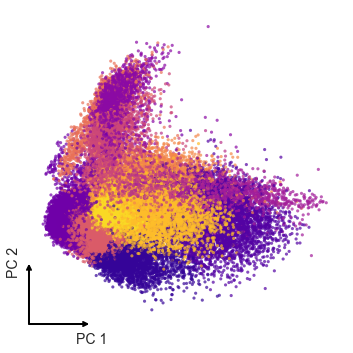

In [7]:
DR_plot(dim_name='PC').plot_IDs(hemato, use_rep='X_pca', obs_col='clusterID', pt_size=10)

In [8]:
%time sc.tl.umap(hemato, random_state=18)

CPU times: user 1min 24s, sys: 4.21 s, total: 1min 29s
Wall time: 1min 6s


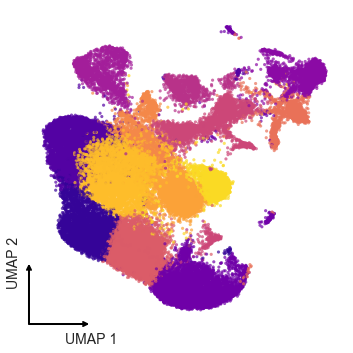

In [9]:
DR_plot(dim_name='UMAP').plot_IDs(hemato, use_rep='X_umap', obs_col='clusterID', pt_size=10)

In [10]:
%time sc.tl.tsne(hemato, random_state=18, perplexity=210, use_rep='X_pca', n_pcs=100)

CPU times: user 10min 32s, sys: 4.9 s, total: 10min 37s
Wall time: 10min 41s


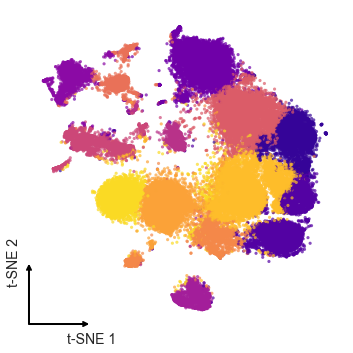

In [11]:
DR_plot(dim_name='t-SNE').plot_IDs(hemato, use_rep='X_tsne', obs_col='clusterID', pt_size=10)

In [12]:
# choose value for K-nearest neighbor calculations. We use 30 because that is the standard perplexity chosen for DR techniques here.
k = 30

In [13]:
%%time
# save distance matrices in AnnData object for easy access
hemato.uns['tsne_distance'] = pdist(hemato.obsm['X_tsne'])
hemato.uns['umap_distance'] = pdist(hemato.obsm['X_umap'])
hemato.uns['pca_distance'] = pdist(hemato.obsm['X_pca'])

CPU times: user 1min 36s, sys: 6.95 s, total: 1min 43s
Wall time: 1min 45s


**t-SNE**

In [14]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['tsne_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))

R: 0.5276
EMD: 0.1449
CPU times: user 1min 39s, sys: 25 s, total: 2min 4s
Wall time: 2min 6s


CPU times: user 24.9 s, sys: 2.17 s, total: 27 s
Wall time: 26.9 s


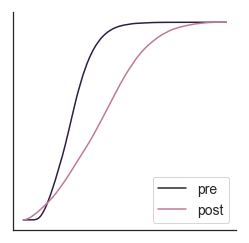

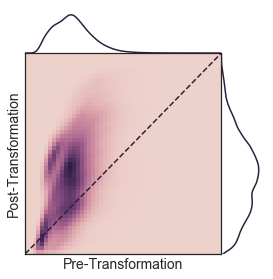

In [15]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

**UMAP**

In [16]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=hemato.uns['pca_distance'], post=hemato.uns['umap_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))

R: 0.5553
EMD: 0.1339
CPU times: user 1min 38s, sys: 14.5 s, total: 1min 53s
Wall time: 1min 54s


CPU times: user 25.2 s, sys: 2.34 s, total: 27.5 s
Wall time: 27.3 s


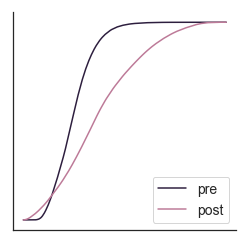

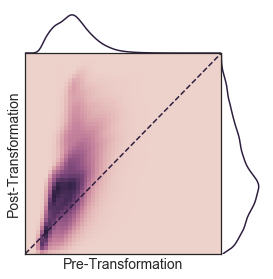

In [17]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

---
### Samusik_01 Hematopoeitic CyTOF Dataset
[FlowRepository FR-FCM-ZZPH](https://flowrepository.org/id/FR-FCM-ZZPH)

In [18]:
sam = sc.read('../inputs/samusik_01.h5ad')

In [24]:
%%time
sam.raw = sam # save raw data before processing
arcsinh(sam, scale=1) # same transformation as Becht, et al.
sam.X = sam.layers['arcsinh_norm'].copy() # put arcsinh-transformed values in default slot

CPU times: user 31.9 ms, sys: 19.6 ms, total: 51.6 ms
Wall time: 68 ms


In [26]:
sam

AnnData object with n_obs × n_vars = 86864 × 39 
    obs: 'Time', 'Cell_length', 'BC1', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'DNA1', 'DNA2', 'Cisplatin', 'beadDist', 'sample', 'event', 'label', 'norm_factor'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'arcsinh_norm'

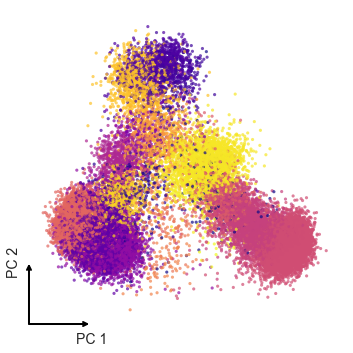

In [25]:
sc.tl.pca(sam, use_highly_variable=False, n_comps=2) # 2-component PCA for comparison to t-SNE and UMAP
DR_plot(dim_name='PC').plot_IDs(sam, use_rep='X_pca', obs_col='label', pt_size=10)

In [27]:
# create neighborhood graphs from PCA results for UMAP
# heads-up: you will get a numba deprecation warning the first time you run this
%time sc.pp.neighbors(sam, n_neighbors=300, use_rep='X', knn=True, random_state=18, metric='euclidean', copy=False)

/Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /Users/cody/.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py (457)

File "../../../.virtualenvs/lau_lab/lib/python3.7/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<funct

CPU times: user 2min 46s, sys: 2.11 s, total: 2min 49s
Wall time: 2min 48s


In [28]:
%time sc.tl.umap(sam, random_state=18)

CPU times: user 3min 55s, sys: 10.9 s, total: 4min 6s
Wall time: 2min 29s


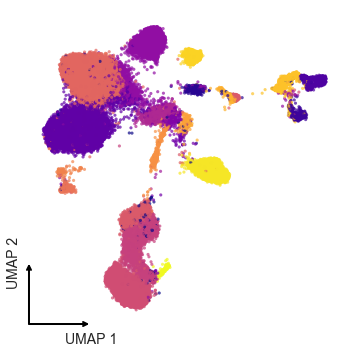

In [30]:
DR_plot(dim_name='UMAP').plot_IDs(sam, use_rep='X_umap', obs_col='label', pt_size=10)

In [31]:
%time sc.tl.tsne(sam, random_state=18, use_rep='X', perplexity=300)

CPU times: user 30min 15s, sys: 13.3 s, total: 30min 29s
Wall time: 30min 30s


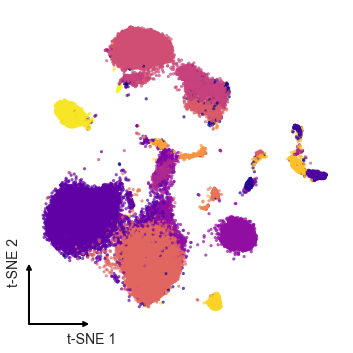

In [32]:
DR_plot(dim_name='t-SNE').plot_IDs(sam, use_rep='X_tsne', obs_col='label', pt_size=10)

In [ ]:
%%time
# save distance matrices in AnnData object for easy access
sam.uns['tsne_distance'] = pdist(sam.obsm['X_tsne'])
sam.uns['umap_distance'] = pdist(sam.obsm['X_umap'])
sam.uns['pca_distance'] = pdist(sam.obsm['X_pca'])
sam.uns['native_distance'] = pdist(sam.X)

**PCA**

In [ ]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=sam.uns['native_distance'], post=sam.uns['pca_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))

In [ ]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

**t-SNE**

In [ ]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=sam.uns['native_distance'], post=sam.uns['tsne_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))

In [ ]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)

**UMAP**

In [ ]:
%%time
pre_flat_norm, post_flat_norm, mantel_stats, EMD = distance_stats(pre=sam.uns['native_distance'], post=sam.uns['umap_distance'], downsample=49995000)
print('R: {}\nEMD: {}'.format(round(mantel_stats[0],4), round(EMD,4)))

In [ ]:
%%time
plt.figure(figsize=(4,4))
plot_cumulative_distributions(pre_flat_norm, post_flat_norm)
joint_plot_distance_correlation(pre_flat_norm, post_flat_norm)